In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import GRU,Dropout, Dense
#from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,LSTM,Dropout
from tensorflow.python.keras.optimizers import RMSprop
#from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [2]:
GivenData = pd.read_csv('GoogleStocks.csv')
GivenData = GivenData.iloc[::-1]
GivenData['avgHighLow'] = (GivenData['high']+GivenData['low'])/2
ConsideredGivenData  = GivenData[['date','avgHighLow','volume','open']]
ConsideredGivenDataShifted = ConsideredGivenData.shift(-1)
Xdata = ConsideredGivenData[['avgHighLow','volume']].values[0:-1]
Ydata = ConsideredGivenDataShifted['open'].values[:-1]
Ydata = Ydata.reshape(len(Ydata),1)

In [3]:
print(type(Xdata))
print(Xdata.shape)
print(type(Ydata))
print(Ydata.shape)

<class 'numpy.ndarray'>
(754, 2)
<class 'numpy.ndarray'>
(754, 1)


In [4]:
Xtrain = Xdata[0:int(0.8*len(Xdata))]
Xtest = Xdata[int(0.8*len(Xdata)):]
Ytrain = Ydata[0:int(0.8*len(Xdata))]
Ytest = Ydata[int(0.8*len(Xdata)):]

In [5]:
Xscaler = MinMaxScaler()
XtrainScaled = Xscaler.fit_transform(Xtrain)
XtestScaled = Xscaler.transform(Xtest)
Yscaler = MinMaxScaler()
YtrainScaled = Yscaler.fit_transform(Ytrain)
YtestScaled = Yscaler.transform(Ytest)

In [6]:
def getBatchData(batchSize, NumOfTimeSteps):
    while True:
        Xdata = np.zeros(shape=(batchSize, NumOfTimeSteps, 2), dtype=np.float16)
        Ydata = np.zeros(shape=(batchSize, NumOfTimeSteps, 1), dtype=np.float16)
        for i in range(batchSize):
            idx = np.random.randint(603 - NumOfTimeSteps)
            Xdata[i] = XtrainScaled[idx:idx+NumOfTimeSteps]
            Ydata[i] = YtrainScaled[idx:idx+NumOfTimeSteps]
        yield (Xdata, Ydata)
def LossFunc(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)
    loss = tf.losses.mean_squared_error(labels=y_true,predictions=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [7]:
def plot_comparison(start_idx, length=100, train=True):
    if train:
        x = XtrainScaled
        y_true = Ytrain
    else:
        x = XtestScaled
        y_true = Ytest
    end_idx = start_idx + length

    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
 
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)

    y_pred_rescaled = Yscaler.inverse_transform(y_pred[0])

    for signal in range(0,1):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel('opening price')
        plt.legend()
        plt.show()

In [8]:
batchSize = 50
#batchData = getBatchData(batchSize,NumOfTimeSteps)

(?, ?, ?)
(?, ?, 1)
Epoch 1/10
80/80 [==============================] - 14s 171ms/step - loss: 0.0409
Epoch 2/10
80/80 [==============================] - 6s 69ms/step - loss: 0.0078
Epoch 3/10
80/80 [==============================] - 6s 69ms/step - loss: 0.0043
Epoch 4/10
80/80 [==============================] - 6s 70ms/step - loss: 0.0029
Epoch 5/10
80/80 [==============================] - 6s 73ms/step - loss: 0.0023
Epoch 6/10
80/80 [==============================] - 6s 70ms/step - loss: 0.0020
Epoch 7/10
80/80 [==============================] - 6s 71ms/step - loss: 0.0018
Epoch 8/10
80/80 [==============================] - 6s 74ms/step - loss: 0.0017
Epoch 9/10
80/80 [==============================] - 6s 70ms/step - loss: 0.0016
Epoch 10/10
80/80 [==============================] - 6s 75ms/step - loss: 0.0015
(?, ?, ?)
(?, ?, 1)
Epoch 1/10
80/80 [==============================] - 18s 222ms/step - loss: 0.0417
Epoch 2/10
80/80 [==============================] - 8s 103ms/step - loss: 0

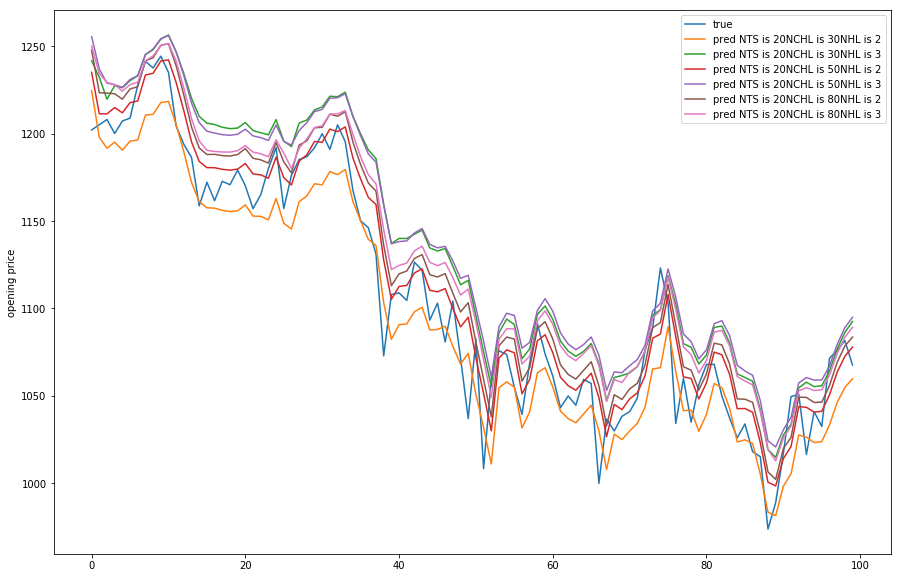

In [19]:
count = 0
plt.figure(figsize=(15,10))
for NumOfTimeSteps in [20]:#,50,75]:
    for nchl in [30,50,80]:
        for nhl in [2,3]:
            batchData = getBatchData(batchSize,NumOfTimeSteps)
            model = Sequential()
            if(nhl==3):
                model.add(GRU(units = nchl, return_sequences = True,input_shape=(None, 2,)))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))
            else:
                model.add(GRU(units = nchl, return_sequences = True,input_shape=(None, 2,)))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))                
            model.add(Dense(1,activation='linear',kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05)))
            optimizer = RMSprop(lr=1e-3)
            model.compile(loss=LossFunc, optimizer=optimizer)
            if 'session' in locals() and session is not None:
                print('Close interactive session')
                session.close()
            model.fit_generator(generator=batchData,epochs=10,steps_per_epoch=80)
            x = XtestScaled
            y_true = Ytest
            x = x[0:100]
            y_true = y_true[0:100]
            x = np.expand_dims(x, axis=0)
            y_pred = model.predict(x)
            #plt.figure(figsize=(15,5))
            y_pred_rescaled = Yscaler.inverse_transform(y_pred[0])
            if count == 0:                
                plt.plot(y_true, label='true')
                plt.plot(y_pred_rescaled, label='pred '+'NTS is '+str(NumOfTimeSteps)+'NCHL is '+str(nchl)+'NHL is '+str(nhl))
            else:
                plt.plot(y_pred_rescaled, label='pred '+'NTS is '+str(NumOfTimeSteps)+'NCHL is '+str(nchl)+'NHL is '+str(nhl))
            count = count+1
            #if count==:
               # plt.ylabel('opening price')
               # plt.legend()
                #plt.show() 
plt.ylabel('opening price')
plt.legend()
plt.show()                
            #plot_comparison(start_idx=0, length=200, train=False)

(?, ?, ?)
(?, ?, 1)
Epoch 1/10
80/80 [==============================] - 23s 288ms/step - loss: 0.0262
Epoch 2/10
80/80 [==============================] - 13s 161ms/step - loss: 0.0061
Epoch 3/10
80/80 [==============================] - 13s 157ms/step - loss: 0.0041
Epoch 4/10
80/80 [==============================] - 12s 155ms/step - loss: 0.0032
Epoch 5/10
80/80 [==============================] - 13s 157ms/step - loss: 0.0026
Epoch 6/10
80/80 [==============================] - 13s 160ms/step - loss: 0.0022
Epoch 7/10
80/80 [==============================] - 13s 163ms/step - loss: 0.0020
Epoch 8/10
80/80 [==============================] - 13s 159ms/step - loss: 0.00193s - loss - ETA: 2s
Epoch 9/10
80/80 [==============================] - 13s 158ms/step - loss: 0.0017
Epoch 10/10
80/80 [==============================] - 13s 157ms/step - loss: 0.00172s -
(?, ?, ?)
(?, ?, 1)
Epoch 1/10
80/80 [==============================] - 31s 389ms/step - loss: 0.0314
Epoch 2/10
80/80 [================

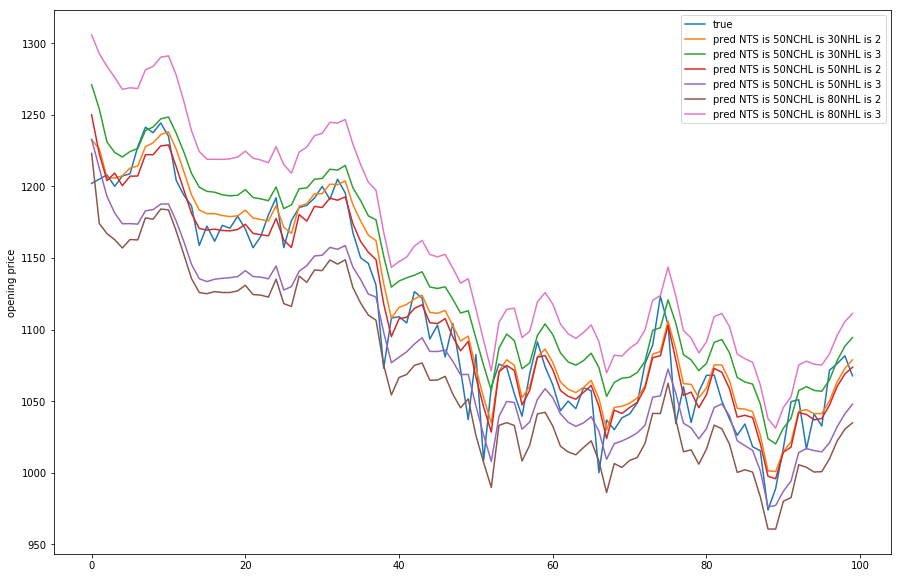

In [20]:
count = 0
plt.figure(figsize=(15,10))
for NumOfTimeSteps in [50]:#,50,75]:
    for nchl in [30,50,80]:
        for nhl in [2,3]:
            batchData = getBatchData(batchSize,NumOfTimeSteps)
            model = Sequential()
            if(nhl==3):
                model.add(GRU(units = nchl, return_sequences = True,input_shape=(None, 2,)))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))
            else:
                model.add(GRU(units = nchl, return_sequences = True,input_shape=(None, 2,)))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))                
            model.add(Dense(1,activation='linear',kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05)))
            optimizer = RMSprop(lr=1e-3)
            model.compile(loss=LossFunc, optimizer=optimizer)
            if 'session' in locals() and session is not None:
                print('Close interactive session')
                session.close()
            model.fit_generator(generator=batchData,epochs=10,steps_per_epoch=80)
            x = XtestScaled
            y_true = Ytest
            x = x[0:100]
            y_true = y_true[0:100]
            x = np.expand_dims(x, axis=0)
            y_pred = model.predict(x)
            #plt.figure(figsize=(15,5))
            y_pred_rescaled = Yscaler.inverse_transform(y_pred[0])
            if count == 0:                
                plt.plot(y_true, label='true')
                plt.plot(y_pred_rescaled, label='pred '+'NTS is '+str(NumOfTimeSteps)+'NCHL is '+str(nchl)+'NHL is '+str(nhl))
            else:
                plt.plot(y_pred_rescaled, label='pred '+'NTS is '+str(NumOfTimeSteps)+'NCHL is '+str(nchl)+'NHL is '+str(nhl))
            count = count+1
            #if count==:
               # plt.ylabel('opening price')
               # plt.legend()
                #plt.show() 
plt.ylabel('opening price')
plt.legend()
plt.show()                
            #plot_comparison(start_idx=0, length=200, train=False)

(?, ?, ?)
(?, ?, 1)
Epoch 1/10
80/80 [==============================] - 33s 418ms/step - loss: 0.0284
Epoch 2/10
80/80 [==============================] - 19s 240ms/step - loss: 0.0057
Epoch 3/10
80/80 [==============================] - 22s 269ms/step - loss: 0.0042
Epoch 4/10
80/80 [==============================] - 21s 260ms/step - loss: 0.0032
Epoch 5/10
80/80 [==============================] - 20s 245ms/step - loss: 0.0027
Epoch 6/10
80/80 [==============================] - 19s 244ms/step - loss: 0.0023
Epoch 7/10
80/80 [==============================] - 20s 254ms/step - loss: 0.0020
Epoch 8/10
80/80 [==============================] - 19s 243ms/step - loss: 0.0018
Epoch 9/10
80/80 [==============================] - 19s 241ms/step - loss: 0.0017
Epoch 10/10
80/80 [==============================] - 20s 251ms/step - loss: 0.0016
(?, ?, ?)
(?, ?, 1)
Epoch 1/10
80/80 [==============================] - 45s 560ms/step - loss: 0.0261
Epoch 2/10
80/80 [==============================] - 30s 3

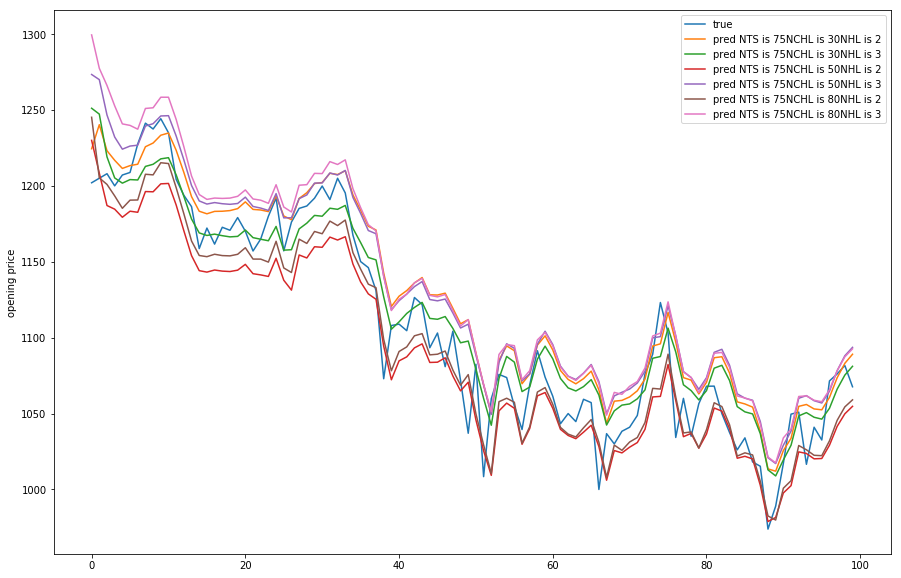

In [21]:
count = 0
plt.figure(figsize=(15,10))
for NumOfTimeSteps in [75]:#,50,75]:
    for nchl in [30,50,80]:
        for nhl in [2,3]:
            batchData = getBatchData(batchSize,NumOfTimeSteps)
            model = Sequential()
            if(nhl==3):
                model.add(GRU(units = nchl, return_sequences = True,input_shape=(None, 2,)))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))
            else:
                model.add(GRU(units = nchl, return_sequences = True,input_shape=(None, 2,)))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))                
            model.add(Dense(1,activation='linear',kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05)))
            optimizer = RMSprop(lr=1e-3)
            model.compile(loss=LossFunc, optimizer=optimizer)
            if 'session' in locals() and session is not None:
                print('Close interactive session')
                session.close()
            model.fit_generator(generator=batchData,epochs=10,steps_per_epoch=80)
            x = XtestScaled
            y_true = Ytest
            x = x[0:100]
            y_true = y_true[0:100]
            x = np.expand_dims(x, axis=0)
            y_pred = model.predict(x)
            #plt.figure(figsize=(15,5))
            y_pred_rescaled = Yscaler.inverse_transform(y_pred[0])
            if count == 0:                
                plt.plot(y_true, label='true')
                plt.plot(y_pred_rescaled, label='pred '+'NTS is '+str(NumOfTimeSteps)+'NCHL is '+str(nchl)+'NHL is '+str(nhl))
            else:
                plt.plot(y_pred_rescaled, label='pred '+'NTS is '+str(NumOfTimeSteps)+'NCHL is '+str(nchl)+'NHL is '+str(nhl))
            count = count+1
            #if count==:
               # plt.ylabel('opening price')
               # plt.legend()
                #plt.show() 
plt.ylabel('opening price')
plt.legend()
plt.show()                
            #plot_comparison(start_idx=0, length=200, train=False)

(?, ?, ?)
(?, ?, 1)
Epoch 1/5
80/80 [==============================] - 53s 659ms/step - loss: 0.0243
Epoch 2/5
80/80 [==============================] - 28s 345ms/step - loss: 0.0075
Epoch 3/5
80/80 [==============================] - 28s 346ms/step - loss: 0.0049
Epoch 4/5
80/80 [==============================] - 28s 348ms/step - loss: 0.0035
Epoch 5/5
80/80 [==============================] - 28s 344ms/step - loss: 0.0027


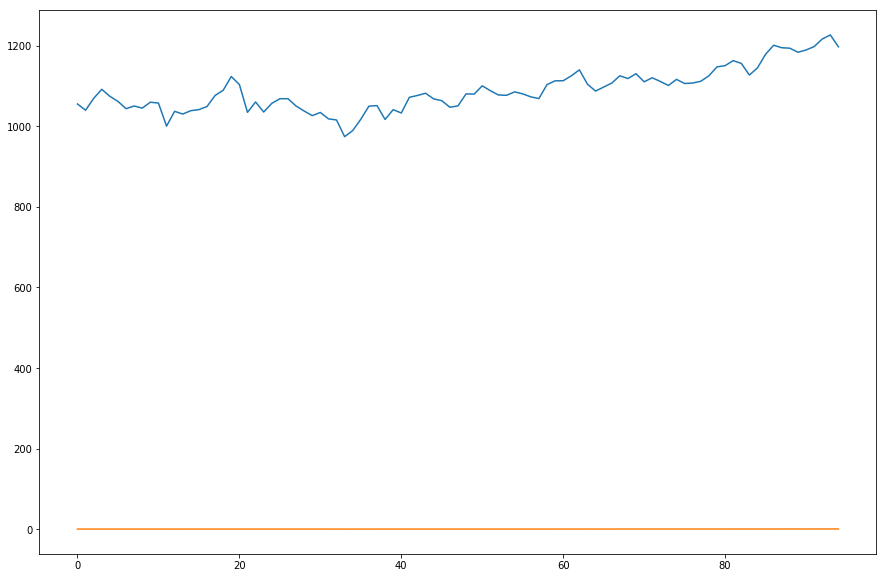

In [26]:
count = 0
plt.figure(figsize=(15,10))
for NumOfTimeSteps in [50]:#,50,75]:
    for nchl in [50]:
        for nhl in [3]:
            batchData = getBatchData(batchSize,NumOfTimeSteps)
            model = Sequential()
            if(nhl==3):
                model.add(GRU(units = nchl, return_sequences = True,input_shape=(None, 2,)))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))
            else:
                model.add(GRU(units = nchl, return_sequences = True,input_shape=(None, 2,)))
                model.add(Dropout(0.2))
                model.add(GRU(units = nchl, return_sequences = True))
                model.add(Dropout(0.2))                
            model.add(Dense(1,activation='linear',kernel_initializer=RandomUniform(minval=-0.05, maxval=0.05)))
            optimizer = RMSprop(lr=1e-3)
            model.compile(loss=LossFunc, optimizer=optimizer)
            if 'session' in locals() and session is not None:
                print('Close interactive session')
                session.close()
            model.fit_generator(generator=batchData,epochs=5,steps_per_epoch=80)
            x = XtestScaled
            y_true = Ytest
            x = x[55:150]
            y_true = y_true[55:150]
            x = np.expand_dims(x, axis=0)
            y_pred = model.predict(x)
            #plt.figure(figsize=(15,5))
            y_pred_rescaled = Yscaler.inverse_transform(y_pred[0])
            if count == 0:                
                plt.plot(y_true, label='true')
                plt.plot(y_pred[0], label='pred '+'NTS is '+str(NumOfTimeSteps)+'NCHL is '+str(nchl)+'NHL is '+str(nhl))
            else:
                plt.plot(y_pred_rescaled, label='pred '+'NTS is '+str(NumOfTimeSteps)+'NCHL is '+str(nchl)+'NHL is '+str(nhl))
            count = count+1
            #if count==:
               # plt.ylabel('opening price')
               # plt.legend()
                #plt.show() 
#plt.ylabel('opening price')
#plt.legend()
#plt.show()                
            #plot_comparison(start_idx=0, length=200, train=False)

for n_hidden_states in [8]:
    for n_latency_days in [20]:#,50,75]:
        max_score = -1000
        max_score_index = 602
        scores = []
        indexs = []
        for day_index in np.arange(602,n_latency_days+5,-1):    
            beginIndex = max(0, day_index - n_latency_days)
            endIndex = max(0, day_index - 1)
            X1 = XtrainScaled[beginIndex:endIndex,0].reshape(-1,1)
            X2 = XtrainScaled[beginIndex:endIndex,1].reshape(-1,1)
            X3 = XtrainScaled[beginIndex:endIndex,2].reshape(-1,1)
            X = np.concatenate([X1, X2, X3])
            #X = np.array(X)
            lengths = [len(X1), len(X2), len(X3)]
            #hmm2 = GaussianHMM(n_components=3, covariance_type='full').fit(X, lengths)  
            #hmm2.n_features = 4
            #if(hmm2.score(X,lengths))>max_score:
             #   max_score = hmm2.score(X,lengths)
              #  max_score_index = day_index
            scores.append(hmm2.score(X,lengths))
            indexs.append(day_index)
        #print(max_score_index)
        #print(max_score)
        
        minimum_score_difference_index = 602
        minimum_score_difference = 1000
        trueValues = []
        predValues = []
        for day_index in range(n_latency_days+5,150):  
            trueValues.append(XtestScaled[day_index,2])
            beginIndex = max(0, day_index - n_latency_days)
            endIndex = max(0, day_index - 1)
            X1 = XtestScaled[beginIndex:endIndex,0].reshape(-1,1)
            X2 = XtestScaled[beginIndex:endIndex,1].reshape(-1,1)
            X3 = XtestScaled[beginIndex:endIndex,2].reshape(-1,1)
            X = np.concatenate([X1, X2, X3])
            ScoreOfCurrentTrainIndex = hmm2.score(X,lengths)
            indexCount = 0
            minIndex = 0
            minScoreDifference = 1000
            minScoreIndex = 0
            for i in scores:
                if(abs(i-ScoreOfCurrentTrainIndex))<minScoreDifference:
                    minScoreDifference = abs(i-ScoreOfCurrentTrainIndex)
                    minIndex = indexCount
                indexCount += 1
            predValues.append(XtrainScaled[indexs[minIndex],2])
        #print(trueValues-predValues) 
        print('n_hidden_states '+str(n_hidden_states))
        print('timeSteps '+str(n_latency_days))
        #plt.figure(figsize=(15,5))
        #plt.plot(np.array(trueValues).reshape(-1,1), label='true')
        plt.plot(np.array(predValues).reshape(-1,1), label='pred')
        plt.legend()
        plt.show()